### Importing Libraries

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from nltk.corpus import stopwords
from wordcloud import WordCloud


import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


from scipy.stats import ttest_ind

Loading BokehJS ...

# Preprocessing the Data

In [2]:
#read the DataFrame
df = pd.read_csv('droz_facebook_statuses.csv')
df.status_message=df.status_message.astype(str)
#df.head()

In [3]:
df.head()

,status_id,status_message,link_name,status_type,status_link,permalink_url,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,35541499994_10150879102584995,Take the quiz now - looking forward to sharing...,Today Health & Wellness,link,http://on.today.com/2vn585K,https://www.facebook.com/droz/posts/1015087910...,2017-08-25 17:30:00,248,7,0,233,12,1,2,0,0
1,35541499994_10150879088644995,I need your opinion for an upcoming show: when...,NaN,status,NaN,https://www.facebook.com/droz/posts/1015087908...,2017-08-25 14:59:58,617,893,20,583,19,4,10,0,1
2,35541499994_10150878608654995,"On today’s show, my friends Dr. Paul Nassif an...",NaN,video,https://www.facebook.com/droz/videos/101508786...,https://www.facebook.com/droz/videos/101508786...,2017-08-25 09:00:00,575,23,37,520,34,17,0,3,1
3,35541499994_10150878614864995,Do yourself a favor - add these to your meals.,9 Spices That Will Fire Up Your Metabolism,link,http://www.doctoroz.com/gallery/9-spices-will-...,https://www.facebook.com/droz/posts/1015087861...,2017-08-24 16:56:39,1266,36,509,1208,50,7,0,0,1
4,35541499994_10150878463884995,Would love you to weigh in on a debate we're h...,Timeline Photos,photo,https://www.facebook.com/droz/photos/a.4112255...,https://www.facebook.com/droz/posts/1015087846...,2017-08-24 12:09:58,1898,1565,91,1658,24,130,70,10,6


In [4]:
#Adding status_lenght and word_count Columns
df['status_length'] = df['status_message'].astype(str).apply(len)
df['word_count'] = df['status_message'].apply(lambda x: len(str(x).split()))
#df.head()

In [5]:
#Removing special charachters and links from status_message
def preprocess(status):
    status = status.str.replace("(<br/>)", "")
    status = status.str.replace('(<a).*(>).*(</a>)', '')
    status = status.str.replace('(&amp)', '')
    status = status.str.replace('(&gt)', '')
    status = status.str.replace('(&lt)', '')
    status = status.str.replace('(\xa0)', ' ')  
    status = status.str.replace('http\S+|www.\S+', '', case=False)
    return status
df['status_message'] = preprocess(df['status_message'])

In [6]:
#lowerCase status_message
df['status_message'] = df['status_message'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Punctuation from status_message
df['status_message'] = df['status_message'].str.replace('[^\w\s]','')

#Removal of Stop Words from status_message
stop = stopwords.words('english')
df['status_message'] = df['status_message'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


#df['status_message'].head()

In [7]:
#Common words in status_message
freq = pd.Series(' '.join(df['status_message']).split()).value_counts()[:100]
#freq

### Descriptive statistics

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 18 columns):
status_id           5144 non-null object
status_message      5144 non-null object
link_name           4072 non-null object
status_type         5144 non-null object
status_link         4472 non-null object
permalink_url       5144 non-null object
status_published    5144 non-null object
num_reactions       5144 non-null int64
num_comments        5144 non-null int64
num_shares          5144 non-null int64
num_likes           5144 non-null int64
num_loves           5144 non-null int64
num_wows            5144 non-null int64
num_hahas           5144 non-null int64
num_sads            5144 non-null int64
num_angrys          5144 non-null int64
status_length       5144 non-null int64
word_count          5144 non-null int64
dtypes: int64(11), object(7)
memory usage: 723.5+ KB


In [9]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,status_length,word_count
count,5144.000000,5144.000000,5144.000000,5144.000000,5144.000000,5144.000000,5144.000000,5144.00000,5144.000000,5144.000000,5144.000000
mean,4612.828927,339.897745,868.475894,4563.185459,25.658243,9.336703,1.774300,11.17224,1.561236,176.940124,31.013219
std,10139.443810,897.317966,2446.157884,10086.084414,169.285417,173.666383,21.738923,301.40104,21.747999,117.635448,20.586695
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,1.000000
25%,878.000000,54.750000,42.000000,856.500000,0.000000,0.000000,0.000000,0.00000,0.000000,116.000000,20.000000
50%,1902.500000,130.000000,200.000000,1877.500000,0.000000,0.000000,0.000000,0.00000,0.000000,160.000000,28.000000
75%,4565.250000,305.000000,713.250000,4527.500000,7.000000,0.000000,0.000000,0.00000,0.000000,215.000000,38.000000
max,219929.000000,28104.000000,60324.000000,219929.000000,4756.000000,12169.000000,751.000000,19972.00000,1151.000000,3800.000000,681.000000


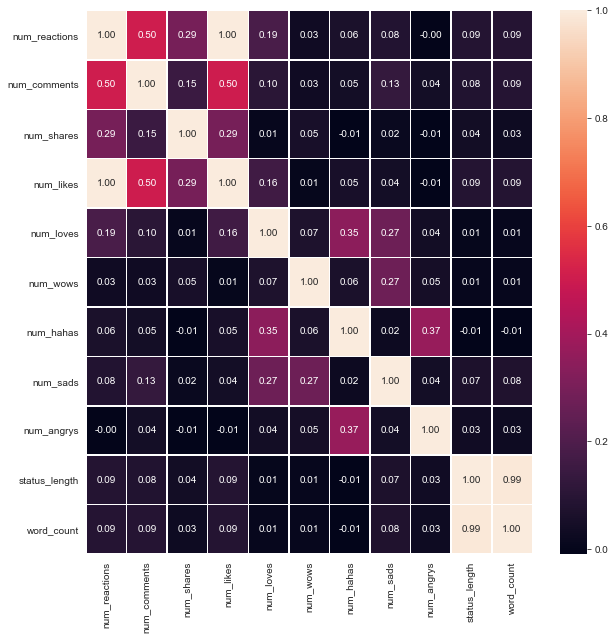

In [10]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, linewidths = .5, fmt = ".2f", ax=ax)

### Most Commented On Posts

In [11]:
top_comments= df.sort_values('num_comments',ascending=False)
top_comments= top_comments['status_message'].head(5)
top_comments

2790    looking healthiest facebook pages favorite pag...
1919    past week lots talk marriage 30 years ago toda...
2867    daughter daphne delivered first child holding ...
3209    food wish calories tell comments ill feature f...
3357    thank kind birthday wishes family friends incl...
Name: status_message, dtype: object

### Most liked Posts

In [12]:
top_reacts= df.sort_values('num_reactions',ascending=False)
top_reacts= top_reacts['status_message'].head(5)
top_reacts

2279    found best present christmas tree yesterday li...
2589    received call alerting robin williams passed a...
1919    past week lots talk marriage 30 years ago toda...
3374    third daughter zoe graduated high school today...
2867    daughter daphne delivered first child holding ...
Name: status_message, dtype: object

### Most Shared Posts

In [13]:
top_shared= df.sort_values('num_shares',ascending=False)
top_shared= top_shared['status_message'].head(5)
top_shared

2146    im sure heard thedress debate captivated inter...
2454    ebola headlines another destructive virus swee...
2786    epsom salt natural exfoliant antiinflammation ...
2514    enlist duo hit market health brain could troub...
2250    todays show met ruby woman amazing story givin...
Name: status_message, dtype: object

# Visualization our Data

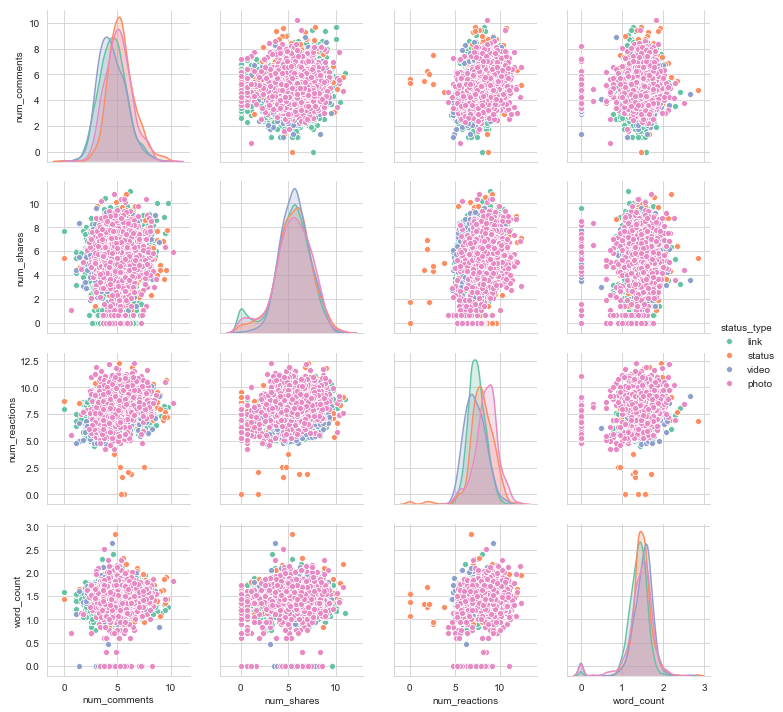

In [14]:
x = df['num_comments'][df.num_comments!=0].dropna()
y = df['num_shares'][df.num_shares!=0].dropna()
z = df['num_reactions'].dropna()
p = df['word_count'][df.word_count!=0].dropna()
t = df['status_type'].dropna()

p = sns.pairplot(pd.DataFrame(list(zip(np.log(x), np.log(y), np.log(z), np.log10(p), t)), 
                        columns=['num_comments','num_shares', 'num_reactions', 'word_count', 'status_type']), hue='status_type', palette="Set2")

In [15]:
cat = df['status_type'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = cat.index,
        values = cat.values,
        hoverinfo = 'label+value'
    
)]

iplot(data, filename='active_category')

In [16]:
df.groupby('status_type').sum()['num_reactions'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Number of Reactions for each Post Type')

In [17]:
trace0 = go.Box(
    y=np.log10(df['num_reactions'][df.status_type=='photo']),
    name = 'Photo',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['num_reactions'][df.status_type=='link']),
    name = 'Link',
    marker = dict(
        color = 'rgb(45, 140, 111)',
    )
)
trace2 = go.Box(
    y=np.log10(df['num_reactions'][df.status_type=='status']),
    name = 'Status',
    marker = dict(
        color = 'rgb(0, 150, 170)',
    )
)
trace3 = go.Box(
    y=np.log10(df['num_reactions'][df.status_type=='video']),
    name = 'Video',
    marker = dict(
        color = 'rgb(12, 10, 140)',
    )
)
layout = go.Layout(
    title = "Number of Reactions for Each Type of Status",
    yaxis= {'title': 'Number of Reactions (log-scaled)'}
)
data = [trace0, trace1, trace2, trace3]
iplot({'data': data, 'layout': layout})

### Timeline Analysis

In [18]:
#Creating Year & Month Columns
df['status_published'] = pd.to_datetime(df['status_published'])
df['Year'] = df['status_published'].apply(lambda time: time.year)
df['Month'] = df['status_published'].apply(lambda time: time.month)
#df.head()

In [19]:
#Removing Outliers in time
df = df[df['Year'] > 2005]

In [20]:
df.shape

(5138, 20)

In [21]:
df.groupby('Year').sum()['num_reactions'].iplot(
    kind='bar', yTitle='Count', linecolor='black', title='number of reactions in each year')

In [22]:
df.groupby('Month').sum()['num_reactions'].iplot(
    kind='bar', yTitle='Count', linecolor='black', title='number of reactions In Months')

### WordCloud for most used words in our posts

<Figure size 1080x720 with 0 Axes>

(-0.5, 999.5, 499.5, -0.5)

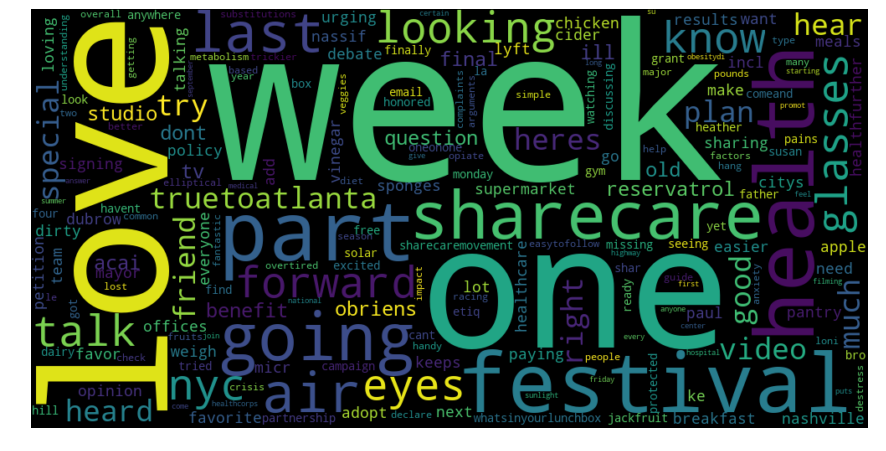

In [23]:
wc = WordCloud(max_words=200,width=1000, height=500)
# generate word cloud
stop = stopwords.words('english')
stop = stop + ['today', 'show' ,'im', 'oprah', 'morning', 'take', 'announcement', 'quiz', 'well', 'proud', 'click', 'uber', 'live', 'upcoming',
            'tomorrow', 'office', 'dr', 'service', 't5l', 'conan', 'start', 'items', 'oz','todays','eclipse','youre','hawks','new','atlanta','keep']

df['status_message'] = df['status_message'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
df.status_message = df.status_message.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
df.dropna(subset=['status_message'], inplace=True)


free = df['status_message'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Searching for Topics

In [24]:
df.loc[df.status_message.str.contains('cancer|carcinoma|sarcoma|leukemia|lymphoma'), 'type'] = 'cancer' 
df.loc[df.status_message.str.contains('flu'), 'type'] = 'flu'
df.loc[df.status_message.str.contains('headache'), 'type'] = 'headache'
df.loc[df.status_message.str.contains('heart disease|heart attack'), 'type'] = 'heart disease'
df.loc[df.status_message.str.contains('diabetes'), 'type'] = 'diabetes'
df.loc[df.status_message.str.contains('ebola'), 'type'] = 'ebola'
df.loc[df.status_message.str.contains('zika'), 'type'] = 'zika virus'
df.loc[df.status_message.str.contains('hiv'), 'type'] = 'hiv'
#df.loc[df1.status_message.str.contains('smok'), 'type'] = 'smoke'
#df.head()

In [25]:
df1 = df.copy()

In [26]:
cate = df['type'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = cate.index,
        values = cate.values,
        hoverinfo = 'label+value'
    
)]

iplot(data, filename='active_category')

In [63]:
df['type'].iplot(
    kind='hist',
    bins=20,
    xTitle='posts',
    linecolor='black',
    yTitle='count',
    title='Comparison Between Diseases')

In [28]:
df.groupby('type').sum()['num_reactions'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='number of reactions for each Disease Type')

# Linear Regression

### Cancer Related Posts Regression

In [29]:
cancer = df[df.type == 'cancer']
cancer.shape

(143, 21)

In [30]:
cancer = cancer[cancer.num_shares != 0] 

In [31]:
cancer.shape

(121, 21)

In [32]:
cancer = cancer[["num_likes","num_loves","num_shares"]]
cancer.head()

,num_likes,num_loves,num_shares
6,149,14,12
35,678,30,234
68,826,31,254
79,1198,41,349
169,321,28,24


In [33]:
names = ["num_likes","num_loves","num_shares"]  #

In [34]:
for i in names:
    cancer[i] = (cancer[i] - min(cancer[i])) / (max(cancer[i]) - min(cancer[i]))

In [35]:
cancer.head()

,num_likes,num_loves,num_shares
6,0.000000,0.098592,0.001719
35,0.036503,0.211268,0.036418
68,0.046715,0.218310,0.039544
79,0.072385,0.288732,0.054392
169,0.011869,0.197183,0.003595


In [36]:
x = cancer.drop(['num_shares'], axis = 1)
y = cancer.num_shares

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=138)

lr = LinearRegression()

lr = lr.fit(x_train,y_train)

accuracy = lr.score(x_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 77.68%'

In [38]:
coeff_df = pd.DataFrame(lr.coef_,x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
num_likes,0.673692
num_loves,0.080890


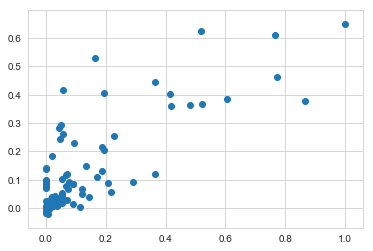

In [39]:
plt.scatter(y_train,lr.predict(x_train))

'Accuracy: 77.68%'

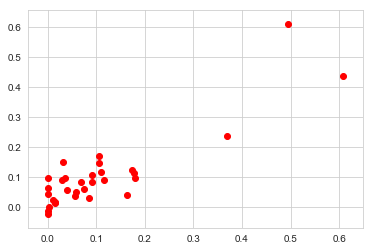

In [40]:
predictions = lr.predict(x_test)

plt.scatter(y_test,predictions, color='red')

accuracy = lr.score(x_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

### Regression On Cancer Related Posts Types

In [41]:
c = df[df.type == 'cancer']
c.shape

(143, 21)

In [42]:
c = c[["num_likes","num_comments","word_count","num_shares","status_type"]]
c.head()

,num_likes,num_comments,word_count,num_shares,status_type
6,149,24,56,12,video
35,678,14,19,234,link
68,826,32,21,254,link
79,1198,24,25,349,link
169,321,98,47,24,video


In [43]:
c = c[c.num_shares != 0] 

In [44]:
encoder = LabelEncoder()
c["status_type"]= encoder.fit_transform(c["status_type"].fillna('Nan'))

In [45]:
c.shape

(121, 5)

In [46]:
names = ["num_likes","num_comments","word_count","num_shares","status_type"]  #

In [47]:
for i in names:
    c[i] = (c[i] - min(c[i])) / (max(c[i]) - min(c[i]))

In [48]:
x = c.drop(['num_shares'], axis = 1)
y = c.num_shares

In [49]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state =138 , test_size=0.25)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_holdout_scaled = scaler.transform(x_test)

In [50]:
lr = LinearRegression().fit(X_train_scaled,y_train)

y_train_pred = lr.predict(X_train_scaled)
#y_test_pred = lr.predict(x_test)
y_test_pred = lr.predict(X_holdout_scaled)

accuracy = lr.score(X_holdout_scaled,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 72.11%'

In [51]:
coeff_df = pd.DataFrame(lr.coef_,x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
num_likes,0.180367
num_comments,-0.039890
word_count,-0.002529
status_type,-0.016032


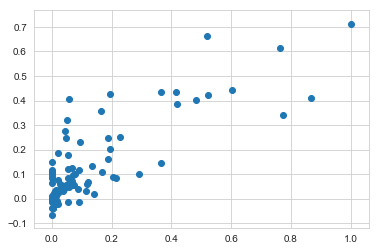

In [52]:
plt.scatter(y_train,lr.predict(X_train_scaled))

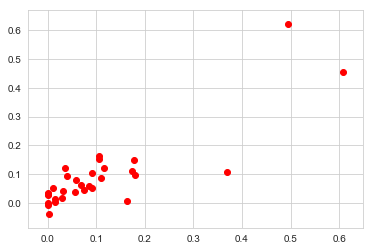

In [53]:
plt.scatter(y_test,y_test_pred, color='red')

## Hypothesis Test

### Independent T-Test

In [54]:
# creating new Feature which represents the reach of a status
df['reach'] = df[['num_likes', 'num_comments', 'num_shares']].mean(axis=1)

In [55]:
flu_mean = df[(df["type"] == 'flu')]
heart_mean = df[(df["type"] == 'heart disease')]

print('t=%.3f, p=%.3f' %(ttest_ind(heart_mean['reach'], 
                                   flu_mean['reach'])))

t=0.719, p=0.474


In [56]:
p = 0.474
alpha = 0.05
# interpret via p-value
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

Accept null hypothesis that the means are equal.


---